In [1]:
#!pip install tensorflow[and-cuda]
#!pip install keras-tuner

In [2]:
#!pip install pandas
#!pip install networkx
#!pip install matplotlib
#!pip install scikit-learn

In [3]:
import pandas as pd
from keras.src.layers import Bidirectional

from component_module import drop_static_columns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# for keras tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras import backend as K
import random
import matplotlib.pyplot as plt
import numpy as np
from time import time
import os
import shutil

2024-10-05 13:52:05.495047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-05 13:52:05.541999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-05 13:52:05.555801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-05 13:52:05.637831: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-05 13:52:06.455755: W tensorflow/compiler/tf2

In [5]:
# Clear TensorFlow GPU memory
#K.clear_session()


In [6]:
# Check if TensorFlow is built with CUDA support
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available")
    print(f"Device: {tf.config.list_physical_devices('GPU')[0]}")
else:
    print("CUDA is not available")

CUDA is available
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1728132750.617715    5120 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728132750.713631    5120 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728132750.713938    5120 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [7]:
#df = pd.read_csv("/home/loz/MSc/MSc_Project/SWaT_12_23_sec_minmax.csv", index_col='time_in_seconds')

In [8]:
#df.head()

In [9]:
# check data is in time order
#df.sort_values(by='time_in_seconds', inplace=True)

In [10]:
#df_just_lit = df.copy()
#df_just_lit.shape

In [11]:
# v2 including MV components
#lit_columns = ['FIT101', 'FIT301', 'FIT401', 'FIT501', 'FIT502','FIT503', 'FIT504',
#                   'MV101', 'MV201', 'MV301', 'MV302', 'MV303', 'MV304',
#                   'P101', 'P203', 'P205', 'P301', 'P302', 'P602']

#lit_columns.sort()
#lit_columns.extend(["LIT101", "LIT301", "LIT401"])

In [12]:
#component_map = list(df.columns)
#len(component_map)

In [13]:
#lit_columns

In [14]:
#lit_101_columns
#df_just_lit = df_just_lit[lit_columns]
#df_just_lit

In [15]:
# force MV values to 0 and 1
#mv_columns = ['MV101', 'MV201', 'MV301', 'MV302', 'MV303', 'MV304']
##df_just_lit[mv_columns] = df_just_lit[mv_columns].replace({0.5: 0, 1: 1})

In [16]:
#df_just_lit101.columns
#df_just_lit.to_csv("/home/loz/MSc/MSc_Project/SWaT_sec_minmax_14_lit_comps.csv")
df_just_lit = pd.read_csv("/home/loz/MSc/MSc_Project/SWaT_sec_minmax_14_lit_comps.csv", index_col='time_in_seconds')

In [17]:
df_just_lit.columns

Index(['FIT101', 'FIT301', 'FIT401', 'FIT501', 'FIT502', 'FIT503', 'FIT504',
       'MV101', 'MV201', 'MV301', 'MV302', 'MV303', 'MV304', 'P101', 'P203',
       'P205', 'P301', 'P302', 'P602', 'LIT101', 'LIT301', 'LIT401'],
      dtype='object')

In [18]:
#df_just_lit.MV302.iloc[2000:8200].plot()

In [19]:
df_just_lit

,FIT101,FIT301,FIT401,FIT501,FIT502,FIT503,FIT504,MV101,MV201,MV301,...,MV304,P101,P203,P205,P301,P302,P602,LIT101,LIT301,LIT401
time_in_seconds,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.937096,0.552146,0.566850,0.541283,0.429823,0.344541,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.990606,0.029293,0.181115
1,0.0,0.936390,0.524523,0.566850,0.421003,0.429823,0.546218,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.989536,0.028592,0.182798
2,0.0,0.936009,0.524523,0.566850,0.408771,0.429823,0.546218,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.989536,0.028592,0.182124
3,0.0,0.935955,0.524523,0.566850,0.460754,0.622810,0.546218,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.989417,0.025785,0.182966
4,0.0,0.935955,0.524523,0.566850,0.580023,0.622810,0.546218,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.988585,0.022277,0.184649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0.0,0.941496,0.616559,0.633712,0.428134,0.429823,0.319327,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.984067,0.779862,0.037199
86396,0.0,0.941496,0.561338,0.633712,0.405708,0.429823,0.319327,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.983948,0.778985,0.039387
86397,0.0,0.941496,0.546018,0.598830,0.509681,0.429823,0.319327,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.983591,0.777055,0.038714


In [20]:
#df_test.set_index('time_in_seconds', inplace=True)
#data_array = df_test.to_numpy()
data_array = df_just_lit.to_numpy()



In [21]:
type(data_array)

numpy.ndarray

In [22]:
# Window size in seconds
#window_size = 20
# Define batch of windows to process in parallel before updating weights 
#batch_size = 32
# use full dataset size to suffle within



def windowed_dataset(data_array, window_size, batch_size, shuffle_buffer_size):
    '''
    get full dataset as np array
    :param data_array: 
    :param window_size: 
    :param batch_size: 
    :param shuffle_buffer_size:  window of data rows to shuffle within
    :return: 
    '''
    
    # Create a TensorFlow dataset from the NumPy array
    dataset = tf.data.Dataset.from_tensor_slices(data_array)

    # Window the dataset into n second long slices with a 1 sec shift between each
    dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
    
    # Flatten the windowed dataset for input layer
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Split window into features and labels (last column of last row) keeping full row as labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1,:]))
    
    # Shuffle the windows to avoid sequencial windows with similar characteristics
    dataset = dataset.shuffle(shuffle_buffer_size)
    

    
    # batch and cache to keep whole dataset in memory. Prefetch to have next batch ready in memory
    dataset = dataset.batch(batch_size)
    #dataset = dataset.cache()
    # set indefinite repeat to allow looping back through
    #dataset = dataset.repeat()
    #dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    # split
    split_time = int(len(data_array) * 0.8)
    
    train_dataset = dataset.take(split_time // batch_size)  # Take the first 80% of batches
    val_dataset = dataset.skip(split_time // batch_size)  # Skip the first 80% of batches
    
    return train_dataset, val_dataset
    
    

In [23]:
train_dataset, val_dataset = windowed_dataset(data_array, 20, 32, 80000)
train_dataset.take(1)
# Check the first window
for features, label in train_dataset.take(1):
    print("Features shape: ", features.shape)  # Should be (32, 19, 22)
    print("Label shape: ", label.shape)        # Should be (32,22)
    

I0000 00:00:1728132765.144045    5120 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728132765.144461    5120 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728132765.144767    5120 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728132765.243585    5120 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Features shape:  (32, 19, 22)
Label shape:  (32, 22)


2024-10-05 13:52:50.014800: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
#sample = train_dataset.take(1)

In [25]:
#for features, label in sample:
 #   print("Features shape: ", label) 

In [84]:


def build_model_tuner(hp, window_size, data_array_shape):
    '''
    Function to build model based on hyper parameters passed by random search
    
    params:
    hp: Hyper parameters passed by random search
     
    returns: 
    model: Keras model
    
    '''
    # Define the model
    model = Sequential()
    

    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array_shape)))
    
    # Range of LSTM units for tuner
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=16)
    # Add an LSTM layer with tuner range 
    model.add(LSTM(units=lstm_units))
    
    # Tune the number of units in the dense layer
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=16)
    model.add(Dense(dense_units, activation='relu'))
    
    # Dense output layer predicting a all components at the next timestep, relu for positive only
    model.add(Dense(data_array_shape, activation='relu'))
    
    # Tune the learning rate for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')
    
    
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model #, epochs, steps_per_epoch



In [86]:


# Directory for model performance logs
LOG_DIR = os.path.join("my_tuner_logs")
BI_LOG_DIR = os.path.join("my_bi_tuner_logs")



shuffle_buffer_size = data_array.shape[0]
# avoid over fitting
early_stop = EarlyStopping(monitor='val_loss', patience=3)




#window_sizes = [n for n in range(20,100,20)]
#batch_sizes = [16,32,64]

window_sizes = [20]
batch_sizes = [16, 32]

# Results Dictionary
results = {}

for window_size in window_sizes:
    for batch_size in batch_sizes:
        print(f'Window Size:{window_size}, Batch Size:{batch_size}')
        train_dataset, val_dataset = windowed_dataset(data_array, window_size, batch_size, shuffle_buffer_size)
        
        # Clear logs to run tuner from scratch
        if os.path.exists(LOG_DIR):
            shutil.rmtree(LOG_DIR) 
            
        num_features = data_array.shape[1]
        
        # keras tuner to find optimum model
        tuner = RandomSearch(
            lambda hp: build_model_tuner(hp, window_size, num_features),
            objective = "val_loss",
            max_trials = 10,
            executions_per_trial = 1,
            directory = LOG_DIR,
            project_name = "lstm_all_data"
        )
        
        early_stop = EarlyStopping(monitor='val_loss', patience=3)
        
        # Train the tuner
        tuner.search(  
            train_dataset,  # Pass your windowed and batched training dataset
            epochs=3,
            validation_data=val_dataset,  # Pass your windowed and batched validation dataset
            callbacks=[early_stop]
        )       
        
        # Retrieve the best model's hyperparameters and scores
        best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
        best_hps = best_trial.hyperparameters.values
        best_score = best_trial.score
        
        # Store the results in the dictionary
        results[f"window_{window_size}_batch_{batch_size}"] = {
            "window_size": window_size,
            "batch_size": batch_size,
            "lstm_units": best_hps['lstm_units'],
            "dense_units": best_hps['dense_units'],
            "learning_rate": best_hps['learning_rate'],
            "MSE": best_score,  # Assuming val_loss is MSE
            "MAE": best_trial.metrics.metrics['mae'].get_statistics()['min']
        }
        
        print(results[f"window_{window_size}_batch_{batch_size}"] )

        
    

Trial 10 Complete [00h 01m 00s]
val_loss: 0.045072536915540695

Best val_loss So Far: 0.0012692050077021122
Total elapsed time: 00h 10m 05s
{'window_size': 20, 'batch_size': 32, 'lstm_units': 32, 'dense_units': 128, 'learning_rate': 0.0003908403370216533, 'MSE': 0.0012692050077021122, 'MAE': 0.013751252554357052}


In [87]:
results

{'window_20_batch_16': {'window_size': 20,
  'batch_size': 16,
  'lstm_units': 48,
  'dense_units': 128,
  'learning_rate': 5.794155666227713e-05,
  'MSE': 0.0018342857947573066,
  'MAE': 0.018209321424365044},
 'window_20_batch_32': {'window_size': 20,
  'batch_size': 32,
  'lstm_units': 32,
  'dense_units': 128,
  'learning_rate': 0.0003908403370216533,
  'MSE': 0.0012692050077021122,
  'MAE': 0.013751252554357052}}

In [88]:
# Best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/home/loz/MSc/MSc_Project/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,102 (55.09 KB)

 Trainable params: 14,102 (55.09 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [90]:
best_hps.values

{'lstm_units': 32, 'dense_units': 128, 'learning_rate': 0.0003908403370216533}

In [91]:


def build_best_model(tuner):
    '''
    Function to build model based on hyper parameters 
    
    params:
    params_dict: params returned from tuner including lstm, dense layer and learning rate
     
    returns: 
    model: Keras model
    
    '''
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    lstm_units = best_hps.values['lstm_units']
    dense_units = best_hps.values['dense_units']
    learning_rate = best_hps.values['learning_rate']
    window_size = 20
    #lstm_units = 80
    #dense_units = 48
    #learning_rate = 1.8345582484066496e-05

    # Define the model
    model = Sequential()
    
    # input shape (window_size - 1, number_of_features)
    # window_size - 1 because we use the previous (window_size - 1) steps to predict the next one
    # The number_of_features is the number of columns in your dataset (data_array.shape[1])
    model.add(Input(shape=(window_size - 1, data_array.shape[1])))
    
    # Add an LSTM layer with best number of units (neurons)
    model.add(LSTM(lstm_units))
    
    # add dense layer
    model.add(Dense(dense_units, activation='relu'))
    
    # Dense output layer predicting the next timestep
    model.add(Dense(data_array.shape[1])) 
    
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with an optimiser and loss function
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model



train_dataset, val_dataset = windowed_dataset(data_array, 20, 32, 80000)
train_dataset.take(1)
# Check the first window
for features, label in train_dataset.take(1):
    print("Features shape: ", features.shape)  # Should be (3219, 14)
    print("Label shape: ", label.shape)        # Should be (32,1)

In [92]:
swat_lstm_lit = build_best_model(tuner)

In [93]:

# Train the model using the already windowed dataset
# Ensure the dataset is batched before training
history = swat_lstm_lit.fit(
    train_dataset,
    epochs=10,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset
)

Epoch 1/10
   2156/Unknown 15s 4ms/step - loss: 0.0330 - mae: 0.0917

2024-10-05 15:00:47.707603: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15277844338687279314
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-05 15:00:47.707663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6820507008634020160
2024-10-05 15:00:47.707705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13543336122234131628


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0329 - mae: 0.0916 - val_loss: 0.0020 - val_mae: 0.0232
Epoch 2/10


2024-10-05 15:00:53.458177: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1623585756994459277
2024-10-05 15:00:53.458244: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6556829098203246445


2153/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - mae: 0.0216

2024-10-05 15:01:07.410778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15277844338687279314
2024-10-05 15:01:07.410828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6820507008634020160
2024-10-05 15:01:07.410869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13543336122234131628


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0018 - mae: 0.0216 - val_loss: 0.0013 - val_mae: 0.0175
Epoch 3/10


2024-10-05 15:01:12.916365: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5960278976086123201
2024-10-05 15:01:12.916407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1623585756994459277
2024-10-05 15:01:12.916419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6556829098203246445


2158/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - mae: 0.0171

2024-10-05 15:01:27.113007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15277844338687279314
2024-10-05 15:01:27.113046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6820507008634020160
2024-10-05 15:01:27.113082: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13543336122234131628


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0012 - mae: 0.0171 - val_loss: 9.5352e-04 - val_mae: 0.0151
Epoch 4/10


2024-10-05 15:01:32.800861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1623585756994459277
2024-10-05 15:01:32.800908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6556829098203246445


2157/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7593e-04 - mae: 0.0146

2024-10-05 15:01:46.937793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15277844338687279314
2024-10-05 15:01:46.937845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6820507008634020160
2024-10-05 15:01:46.937886: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13543336122234131628


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 9.7580e-04 - mae: 0.0146 - val_loss: 8.4737e-04 - val_mae: 0.0141
Epoch 5/10


2024-10-05 15:01:52.142811: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5960278976086123201
2024-10-05 15:01:52.142857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1623585756994459277
2024-10-05 15:01:52.142869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6556829098203246445


2157/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5492e-04 - mae: 0.0133

2024-10-05 15:02:06.270729: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15277844338687279314
2024-10-05 15:02:06.270769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6820507008634020160
2024-10-05 15:02:06.270797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13543336122234131628


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 8.5489e-04 - mae: 0.0133 - val_loss: 8.1284e-04 - val_mae: 0.0127
Epoch 6/10


2024-10-05 15:02:11.894052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1623585756994459277
2024-10-05 15:02:11.894100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6556829098203246445


2157/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7797e-04 - mae: 0.0124

2024-10-05 15:02:25.846186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15277844338687279314
2024-10-05 15:02:25.846236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6820507008634020160
2024-10-05 15:02:25.846282: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13543336122234131628


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 7.7797e-04 - mae: 0.0124 - val_loss: 8.1716e-04 - val_mae: 0.0118
Epoch 7/10


2024-10-05 15:02:31.301989: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1623585756994459277
2024-10-05 15:02:31.302038: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6556829098203246445


2150/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5182e-04 - mae: 0.0118

2024-10-05 15:02:44.818642: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15277844338687279314
2024-10-05 15:02:44.818683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6820507008634020160
2024-10-05 15:02:44.818712: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13543336122234131628


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 7.5183e-04 - mae: 0.0118 - val_loss: 7.4683e-04 - val_mae: 0.0118
Epoch 8/10


2024-10-05 15:02:50.333819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1623585756994459277
2024-10-05 15:02:50.333867: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6556829098203246445


2153/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2617e-04 - mae: 0.0113

2024-10-05 15:03:04.644036: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15277844338687279314
2024-10-05 15:03:04.644091: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6820507008634020160
2024-10-05 15:03:04.644133: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13543336122234131628


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 7.2621e-04 - mae: 0.0113 - val_loss: 7.6557e-04 - val_mae: 0.0120
Epoch 9/10


2024-10-05 15:03:10.144346: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1623585756994459277


2157/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4958e-04 - mae: 0.0110

2024-10-05 15:03:24.139974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15277844338687279314
2024-10-05 15:03:24.140016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6820507008634020160
2024-10-05 15:03:24.140046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13543336122234131628


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 7.4952e-04 - mae: 0.0110 - val_loss: 6.6574e-04 - val_mae: 0.0100
Epoch 10/10


2024-10-05 15:03:29.616342: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1623585756994459277
2024-10-05 15:03:29.616387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6556829098203246445


2156/2160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3581e-04 - mae: 0.0108

2024-10-05 15:03:43.618257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15277844338687279314
2024-10-05 15:03:43.618295: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6820507008634020160
2024-10-05 15:03:43.618329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13543336122234131628


2160/2160 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 7.3575e-04 - mae: 0.0108 - val_loss: 6.6821e-04 - val_mae: 0.0099


2024-10-05 15:03:49.741131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1623585756994459277
2024-10-05 15:03:49.741169: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6556829098203246445


In [94]:
swat_lstm_lit.save('swat_lstm_22_full_output.keras')

In [95]:
swat_lstm_lit

<Sequential name=sequential_1, built=True>

## Tuner Version

# Open Saved Model

In [96]:
# Load the model from the SavedModel directory
# 20 secs
#swat_lstm = tf.keras.models.load_model('swat_lstm_1_0.keras')
#swat_lstm = tf.keras.models.load_model('best_model.keras')
#model_window = 20
# only for predict so no optimiser so compile  = false
swat_lstm_lit = tf.keras.models.load_model('swat_lstm_22_full_output.keras', compile=False)
#model_window = 20

In [97]:
# Reshape the input from data_array to add the batch dimension
model_window = 20
reshaped_input = data_array[:model_window-1, :].reshape(1, model_window-1, data_array.shape[1])  # (1, 19, 22)


In [98]:
reshaped_input.shape

(1, 19, 22)

In [99]:
reshaped_input

array([[[0.        , 0.93709565, 0.55214592, 0.56685038, 0.54128302,
         0.4298233 , 0.34454123, 0.        , 1.        , 0.        ,
         1.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 1.        , 0.        , 0.99060632,
         0.02929309, 0.18111452],
        [0.        , 0.93638966, 0.52452306, 0.56685038, 0.42100321,
         0.4298233 , 0.54621783, 0.        , 1.        , 0.        ,
         1.        , 0.        , 0.        , 1.        , 1.        ,
         0.        , 0.        , 1.        , 0.        , 0.9895364 ,
         0.02859152, 0.18279767],
        [0.        , 0.93600931, 0.52452306, 0.56685038, 0.4087715 ,
         0.4298233 , 0.54621783, 0.        , 1.        , 0.        ,
         1.        , 0.        , 0.        , 1.        , 1.        ,
         0.        , 0.        , 1.        , 0.        , 0.9895364 ,
         0.02859152, 0.18212441],
        [0.        , 0.93595504, 0.52452306, 0.56685038, 0.46075428,
 

In [100]:

# Make predictions
predictions = swat_lstm_lit.predict(reshaped_input)

# Print predictions
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[[-5.8089485e-03  9.3357176e-01  5.8771783e-01  5.5951691e-01
   5.0712746e-01  3.6959007e-01  2.7061689e-01 -5.7126917e-03
   1.0073981e+00 -3.0393526e-04  9.9543869e-01  1.3326528e-03
  -2.7479064e-03  1.0123413e+00  9.9841028e-01 -5.7877027e-03
   1.1285227e-03  9.9973530e-01  5.7621626e-04  9.6822280e-01
   2.1274531e-02  1.9130665e-01]]


In [101]:
predictions_lit = predictions[0, -3:].reshape(1,3)
predictions_lit.shape

(1, 3)

In [102]:
lit101, lit301, lit401 = predictions_lit[0]

In [103]:
lit101

0.9682228

In [104]:
actual = data_array[model_window-1:model_window, -3:]

In [105]:
actual.shape

(1, 3)

In [106]:
reshaped_input.shape

(1, 19, 22)

In [107]:
actual

array([[0.96908448, 0.01052475, 0.18902553]])

In [108]:
difference = actual - predictions_lit

# Print results
print("Predictions:\n", predictions_lit)
print("Actual Values:\n", actual)
print("Difference:\n", difference)

Predictions:
 [[0.9682228  0.02127453 0.19130665]]
Actual Values:
 [[0.96908448 0.01052475 0.18902553]]
Difference:
 [[ 0.00086168 -0.01074978 -0.00228112]]


In [109]:
type(difference)

numpy.ndarray

# Predict Whole Dataset

In [110]:
split_time = int(data_array.shape[0] * 0.8)

val_dataset = data_array[split_time:]
##predict first 100 
predict_dataset = val_dataset[:1200]

In [111]:
#predict_dataset

In [112]:
#len(val_dataset)

In [113]:
#input_window.shape

In [114]:
# Define a list to hold all predictions
all_predictions_lit101 = []
all_predictions_lit301 = []
all_predictions_lit401 = []

# Loop through the dataset and predict step by step
for i in range(len(predict_dataset) - model_window + 1):
    # Extract the window of input data for prediction
    input_window = predict_dataset[i:i+model_window-1, :].reshape(1, model_window-1, data_array.shape[1])
    
    # Predict the next timestep
    predictions = swat_lstm_lit.predict(input_window)
    # reshape
    predictions = predictions[0, -3:].reshape(1,3)
    lit101, lit301, lit401 = predictions[0]
    
    # Save prediction
    all_predictions_lit101.append(lit101)  
    all_predictions_lit301.append(lit301)
    all_predictions_lit401.append(lit401)

# Convert predictions list to numpy array
all_predictions_lit101 = np.array(all_predictions_lit101)
all_predictions_lit301 = np.array(all_predictions_lit301)
all_predictions_lit401 = np.array(all_predictions_lit401)

index = np.arange(model_window - 1, len(predict_dataset))


df_predictions = pd.DataFrame({
    "LIT101": all_predictions_lit101,
    "LIT301": all_predictions_lit301,
    "LIT401": all_predictions_lit401
}, index=index)


# Convert predictions list to numpy array
#all_predictions = np.array(all_predictions)


# Get the actual data for comparison (the next step in each window)
actual_data_lit101 = predict_dataset[model_window - 1:, -3]  # Adjust index based on LIT101's position
actual_data_lit301 = predict_dataset[model_window - 1:, -2]  # Adjust index based on LIT301's position
actual_data_lit401 = predict_dataset[model_window - 1:, -1]  # Adjust index based on LIT401's position

mae_lit101 = np.mean(np.abs(all_predictions_lit101 - actual_data_lit101))
mae_lit301 = np.mean(np.abs(all_predictions_lit301 - actual_data_lit301))
mae_lit401 = np.mean(np.abs(all_predictions_lit401 - actual_data_lit401))

#df_predictions = pd.DataFrame({"LIT101": all_predictions}, index=index)


#  error metrics
mae_lit101 = np.mean(np.abs(all_predictions_lit101 - actual_data_lit101))
mae_lit301 = np.mean(np.abs(all_predictions_lit301 - actual_data_lit301))
mae_lit401 = np.mean(np.abs(all_predictions_lit401 - actual_data_lit401))

print(f"Mean Absolute Error for LIT101: {mae_lit101}")
print(f"Mean Absolute Error for LIT301: {mae_lit301}")
print(f"Mean Absolute Error for LIT401: {mae_lit401}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

In [115]:
actual_data

NameError: name 'actual_data' is not defined

In [116]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1181 entries, 19 to 1199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LIT101  1181 non-null   float32
 1   LIT301  1181 non-null   float32
 2   LIT401  1181 non-null   float32
dtypes: float32(3)
memory usage: 23.1 KB


In [117]:
predict_dataset.shape

(1200, 22)

In [118]:
actual_values = predict_dataset[-1,:]

In [119]:
actual_values

array([0.        , 0.93964866, 0.70244393, 0.64244404, 0.54433895,
       0.33333333, 0.30252145, 0.        , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 1.        ,
       1.        , 0.        , 1.        , 0.        , 0.50523195,
       0.09279063, 0.30028659])

In [120]:
all_predictions.shape

NameError: name 'all_predictions' is not defined

In [121]:
predict_dataset = predict_dataset[window_size-1:]

In [122]:
# Shift predictions by 1 step forward to account for the lag
shifted_predictions = np.insert(all_predictions, 0, np.nan)  # Insert NaN at the beginning to shift predictions
shifted_predictions = shifted_predictions[:-1]  # Remove the last value to maintain the array length

# Compare shifted predictions to the original actual data
mae = np.mean(np.abs(shifted_predictions[~np.isnan(shifted_predictions)] - actual_data))
print(f"Mean Absolute Error: {mae}")


NameError: name 'all_predictions' is not defined

In [123]:
df_actual = pd.DataFrame(predict_dataset, columns=lit_101_columns)
df_actual.info

NameError: name 'lit_101_columns' is not defined

In [124]:
actual = df_actual['LIT101'].to_list()

NameError: name 'df_actual' is not defined

In [125]:
actual

array([[0.96908448, 0.01052475, 0.18902553]])

In [126]:
predictions = df_predictions['LIT101'].to_list()

In [127]:
df_predictions['LIT101'].shape

(1181,)

In [128]:
len(predictions_trim)

NameError: name 'predictions_trim' is not defined

In [129]:
len(actual_trim)

NameError: name 'actual_trim' is not defined

In [130]:
predictions_trim = predictions[1:]
actual_trim = actual[:-3]

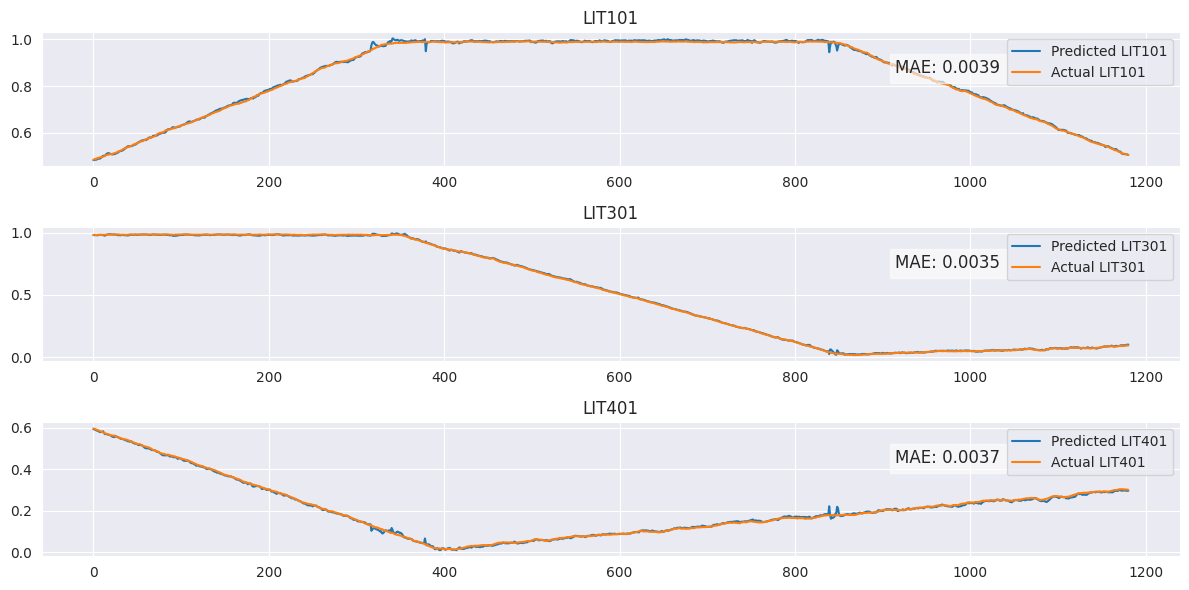

Mean Absolute Error for LIT101: 0.00387703167229184
Mean Absolute Error for LIT301: 0.0034669022303329485
Mean Absolute Error for LIT401: 0.00370338623482329


In [133]:

# Plot predictions vs. actual for each variable on the same plot
plt.figure(figsize=(12, 6))

# LIT101
plt.subplot(3, 1, 1)  # Create a 3x1 grid of plots, this is the first plot
plt.plot(all_predictions_lit101, label='Predicted LIT101')
plt.plot(actual_data_lit101, label='Actual LIT101')
plt.title('LIT101')
plt.legend()
plt.text(0.75, 0.8, f'MAE: {mae_lit101:.4f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

# LIT301
plt.subplot(3, 1, 2)  # This is the second plot in the 3x1 grid
plt.plot(all_predictions_lit301, label='Predicted LIT301')
plt.plot(actual_data_lit301, label='Actual LIT301')
plt.title('LIT301')
plt.legend()
plt.text(0.75, 0.8, f'MAE: {mae_lit301:.4f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

# LIT401
plt.subplot(3, 1, 3)  # This is the third plot in the 3x1 grid
plt.plot(all_predictions_lit401,  label='Predicted LIT401')
plt.plot(actual_data_lit401, label='Actual LIT401')
plt.title('LIT401')
plt.legend()
plt.text(0.75, 0.8, f'MAE: {mae_lit401:.4f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('/home/loz/MSc/MSc_Project/Write_Up/Charts/lit101_301_401_dnn.jpeg')
plt.show()

# Print MAE for each variable
print(f"Mean Absolute Error for LIT101: {mae_lit101}")
print(f"Mean Absolute Error for LIT301: {mae_lit301}")
print(f"Mean Absolute Error for LIT401: {mae_lit401}")


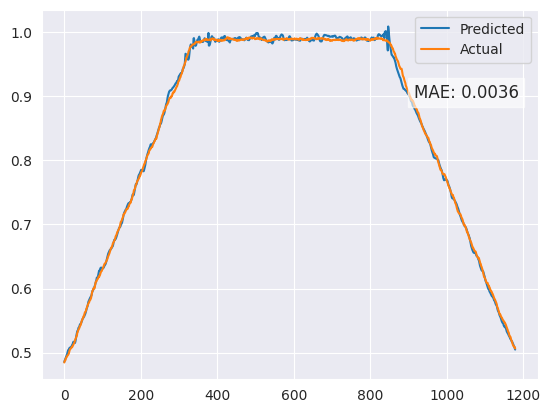

In [145]:
#plt.plot(df_actual['LIT101'], label='Actual')
#plt.plot(df_predictions['LIT101'], label='Predicted')

plt.plot(predictions_trim, label='Predicted')
plt.plot(actual_trim, label='Actual')

#plt.title('LIT101 Model Evaluation')
mae = np.mean(np.abs(np.array(predictions_trim) - np.array(actual_trim)))
plt.legend()
# Add text annotation for MAE on the plot
plt.text(0.75, 0.8, f'MAE: {mae:.4f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))
plt.savefig('/home/loz/MSc/MSc_Project/Write_Up/Charts/lit101_only_dnn.jpeg')
plt.show()
#mae = np.mean(np.abs(df_predictions['LIT101'] - df_actual['LIT101']))
#mae = np.mean(np.abs(np.array(predictions_trim) - np.array(actual_trim)))
#print(f"Mean Absolute Error: {mae}")

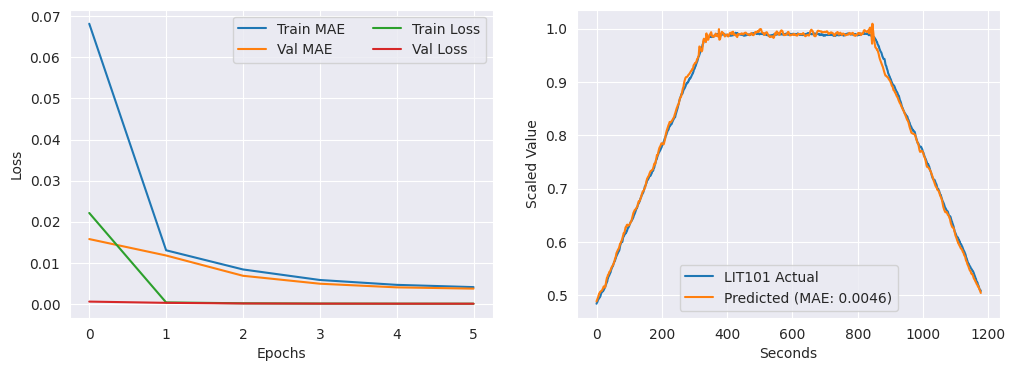

In [149]:
history_1_dict = history.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)

if 'mae' in history_1_dict:
    plt.plot(history_1_dict['mae'], label='Train MAE')
if 'val_mae' in history_1_dict:
    plt.plot(history_1_dict['val_mae'], label='Val MAE')
    
if 'loss' in history_1_dict:
    plt.plot(history_1_dict['loss'], label='Train Loss')
if 'val_loss' in history_1_dict:
    plt.plot(history_1_dict['val_loss'], label='Val Loss')
        
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(ncol=2)

# Plot accuracy 
plt.subplot(1, 2, 2)

actual = df_actual['LIT101'].to_list()
predictions = df_predictions['LIT101'].to_list()

actual_trim = np.array(actual[:-3])
predictions_trim = np.array(predictions[3:])


#plt.plot(df_actual['LIT101'].iloc[:], label='Actual')
#plt.plot(df_predictions['LIT101'], label='Predicted')

plt.plot(actual_trim, label='Actual')
plt.plot(predictions_trim, label='Predicted')

#mae = np.mean(np.abs(df_predictions['LIT101'] - df_actual['LIT101']))
mae = np.mean(np.abs(predictions_trim - actual_trim))
plt.legend([f'LIT101 Actual', f'Predicted (MAE: {mae:.4f})'])


plt.xlabel('Seconds')
plt.ylabel('Scaled Value')

# Show the plots
#plt.tight_layout()

# Save the plot to a file (e.g., "plot.png")
plt.savefig('/home/loz/MSc/MSc_Project/Write_Up/Charts/lit101_only_dnn.jpeg')
plt.show()

# Train Agent

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [ ]:
print('test')